In [1]:
# Standard Python modules
import os, sys
import yaml
from pathlib import Path
import numpy as np
import pandas as pd
import xarray as xr
# matplotlib
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import AxesGrid
from matplotlib import rcParams
from matplotlib.colors import ListedColormap
# plot styles/formatting
import seaborn as sns
import cmocean.cm as cmo
import cmocean
# cartopy
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes

# Extra 
from scipy.ndimage import gaussian_filter    # smoothing contour lines
import metpy.calc as mpcalc
from metpy.units import units
from IPython.display import Image, display

# import personal modules
# Path to modules
sys.path.append('../modules')
# Import my modules
from plotter import draw_basemap, add_subregion_boxes, make_cmap
import nclcmaps as nclc
from timeseries import persistence, select_months, create_list_all_dates
from teleconnections import build_teleconnection_df, mjo_index
from statistical_tests import xr_ttest_ind_from_stats, ttest_1samp_new
from ar_funcs import ar_daily_df

In [2]:
# Set up paths

path_to_data = '/home/nash/DATA/data/'                            # project data -- read only
path_to_out  = '/home/nash/DATA/repositories/AR_types/out/'       # output files (numerical results, intermediate datafiles) -- read & write
path_to_figs = '/home/nash/DATA/repositories/AR_types/figs/'      # figures

### Data

In [3]:
# choose season
ssn = 'djfmam'
ceofid = 'HUV500'
neofs = 2 # choose number of eofs
nk = 3 # choose number of clusters

out_path = path_to_out + ceofid + '/' + ssn + '/' + 'neof' + str(neofs) + '/k' + str(nk) + '/'
fig_path = path_to_figs + ceofid + '/' + ssn + '/'+ 'neof' + str(neofs) + '/k' + str(nk) + '/'

In [4]:
# import configuration file for dictionary choice
yaml_doc = '../data/config.yml'

config = yaml.load(open(yaml_doc), Loader=yaml.SafeLoader)
#select dictionaries - choose var, anom/nanom, and season
# upper_ precip_ ivt_ and non_anom anom
plot_dict_upper = config['upper_anom']
plot_dict_ivt = config['ivt_anom']
plot_dict_prec = config['precip_anom']
plot_dict_iwv = config['iwv_diff']
plot_dict_500 = config['lower_diff']

plot_dicts = [plot_dict_upper, plot_dict_500, plot_dict_ivt, plot_dict_prec]

# djf_dict mam_dict djfmam_dict
ar_dict = config[ssn]

#### AR days and Climate Indices

In [5]:
outpath = path_to_out + ceofid + '/' + ssn + '/' + 'neof' + str(neofs) + '/k' + str(nk) + '/'
start_date = '1979-12-01'
end_date = '2019-05-31'

# climate index df
tele = build_teleconnection_df('daily', 'COND', start_date, end_date)
mjo = mjo_index('daily', ar_dict['start_date'], ar_dict['end_date'])
tele['MJO'] = mjo['COND']
df_index = select_months(tele, 12, 5)

df = ar_daily_df(ssn, nk, outpath)
# combine ar df with tele df
# join indices with AR count
new_df = df.join(df_index)
new_df

,AR_CAT1,AR_CAT2,AR_CAT3,AR_ALL,AR_CAT,AO,PDO,ENSO,SH,MJO
date,,,,,,,,,,
1979-12-01 09:00:00,0.0,0.0,1.0,1.0,3,1,0,0,0,1
1979-12-02 09:00:00,0.0,0.0,1.0,1.0,3,1,0,0,0,1
1979-12-03 09:00:00,0.0,0.0,0.0,0.0,0,1,0,0,0,1
1979-12-04 09:00:00,0.0,0.0,0.0,0.0,0,1,0,0,0,1
1979-12-05 09:00:00,0.0,0.0,0.0,0.0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...
2019-05-27 09:00:00,0.0,0.0,0.0,0.0,0,0,0,1,1,1
2019-05-28 09:00:00,0.0,0.0,0.0,0.0,0,-1,0,1,1,1
2019-05-29 09:00:00,0.0,0.0,0.0,0.0,0,-1,0,1,1,1


#### ERA5

In [6]:
rename_dict_upper = {'z': 'H', 
                     'u': 'U250', 
                     'v':'V250', 
                     'q': 'QV',
                     'latitude': 'lat',
                     'longitude': 'lon'}

rename_dict_prec = {'mtpr': 'prec', 
                    'latitude': 'lat',
                    'longitude': 'lon'}

rename_dict_iwv = {'latitude': 'lat',
                    'longitude': 'lon'}

rename_dict_lower = {'z': 'H500', 
                     'u': 'U500', 
                     'v':'V500', 
                     'q': 'QV',
                     'latitude': 'lat',
                     'longitude': 'lon'}

rename_dict_ivt = {'p71.162': 'ivte', 
                   'p72.162': 'ivtn', 
                   'latitude': 'lat',
                   'longitude': 'lon'}

In [7]:
def preprocess(ds):
    '''keep only selected lats and lons'''
    if plot_dict['name'] == 'huv250':
        subset = ds.sel(latitude=slice(latmax, latmin), longitude=slice(lonmin, lonmax), level=plot_dict['lev'])
        subset = subset.rename(rename_dict_upper)
        subset = subset.drop(['QV'])
    if plot_dict['name'] == 'prec':
        subset = ds.sel(latitude=slice(latmax, latmin), longitude=slice(lonmin, lonmax))
        subset = subset.rename(rename_dict_prec)
    if plot_dict['name'] == 'huv500':
        subset = ds.sel(latitude=slice(latmax, latmin), longitude=slice(lonmin, lonmax), level=plot_dict['lev'])
        subset = subset.rename(rename_dict_lower)
        subset = subset.drop(['QV'])
    if plot_dict['name'] == 'iwv':
        subset = ds.sel(latitude=slice(latmax, latmin), longitude=slice(lonmin, lonmax))
        subset = subset.rename(rename_dict_iwv)
        subset = subset.drop(['tcrw', 'tcsw', 'tcw'])
    if plot_dict['name'] == 'ivt':
        subset = ds.sel(latitude=slice(latmax, latmin), longitude=slice(lonmin, lonmax))
        subset = subset.rename(rename_dict_ivt)
        
    return subset

f = []

# Select lat/lon grid
lonmin = 20
lonmax = 120
latmin = 5
latmax = 55

    
for p, plot_dict in enumerate(plot_dicts):

    # # open data  
    f.append(xr.open_mfdataset(path_to_data + plot_dict['fname'] , preprocess=preprocess, combine='by_coords'))

ds = xr.merge(f[:3], compat='override')
print('ds size in GB {:0.2f}\n'.format(ds.nbytes / 1e9))
# f[0]['H'] = f[0]['H']/(9.80665), # convert to geopotential height (m)
# f[1]['prec'] = f[1]['prec']*86400 # convert to mm day-1



ds size in GB 19.46



In [8]:
# import precipitation averages for AR Types
fname = path_to_out+'precip_djfmam_h500_eof2_k3.nc'
precipitation = xr.open_dataset(fname)
precipitation

<xarray.Dataset>
Dimensions:  (ar: 3, lat: 221, lon: 361)
Coordinates:
  * lat      (lat) float32 55.0 54.75 54.5 54.25 54.0 ... 1.0 0.75 0.5 0.25 0.0
  * lon      (lon) float32 20.0 20.25 20.5 20.75 ... 109.25 109.5 109.75 110.0
  * ar       (ar) int64 1 2 3
Data variables:
    prec     (ar, lat, lon) float64 ...

#### Combine Data

In [9]:
%%time
df = new_df
ds_lst = [ds, f[3]]
for i, ds in enumerate(ds_lst):
    # Trim date range
    idx = slice(ar_dict['start_date'], ar_dict['end_date'])
    ds = ds.sel(time=idx)
    
    # Select months
    if ar_dict['mon_s'] > ar_dict['mon_e']:
        idx = (ds.time.dt.month >= ar_dict['mon_s']) | (ds.time.dt.month <= ar_dict['mon_e'])
    else:
        idx = (ds.time.dt.month >= ar_dict['mon_s']) & (ds.time.dt.month <= ar_dict['mon_e'])
    ds = ds.sel(time=idx)
    
    # Combine AR Cat data w/ reanalysis data
    # Add ar time series to the ERA dataset
    cols = ['AR_CAT', 'AO', 'PDO', 'ENSO', 'SH', 'MJO']
    
    for k, col in enumerate(cols):
        ds[col] = ('time', df[col])

    ds = ds.set_coords(tuple(cols))
    
    # select only AR days
    idx = (ds.AR_CAT > 0)
    ds = ds.sel(time=idx)
    print('ds size in GB {:0.2f}\n'.format(ds.nbytes / 1e9))
    ds = ds.load()
    ds_lst[i] = ds

ds size in GB 0.99

ds size in GB 0.49

CPU times: user 16.4 s, sys: 2min 53s, total: 3min 10s
Wall time: 4min 56s


In [10]:
## calculate 500 hPa wind speed and IVT
ds = ds_lst[0]
# ds = ds.assign(wspd=lambda ds: np.sqrt(ds.U500**2 + ds.V500**2))
ds = ds.assign(ivt=lambda ds: np.sqrt(ds.ivte**2 + ds.ivtn**2))
ds_lst[0] = ds
ds_lst[0]

<xarray.Dataset>
Dimensions:    (lat: 101, lon: 201, time: 759)
Coordinates:
  * lat        (lat) float32 55.0 54.5 54.0 53.5 53.0 ... 7.0 6.5 6.0 5.5 5.0
  * lon        (lon) float32 20.0 20.5 21.0 21.5 ... 118.5 119.0 119.5 120.0
    level      float64 250.0
  * time       (time) datetime64[ns] 1979-12-01T09:00:00 ... 2019-04-24T09:00:00
    dayofyear  (time) int64 335 336 24 43 44 56 57 ... 86 87 99 105 106 113 114
    AR_CAT     (time) int64 3 3 3 2 1 3 3 1 3 2 3 1 ... 3 3 1 3 3 3 3 2 2 1 3 3
    AO         (time) int64 1 1 -1 -1 -1 0 0 -1 0 0 -1 ... 1 1 1 1 1 -1 0 0 1 1
    PDO        (time) int64 0 0 0 1 1 1 1 1 1 1 1 1 ... -1 -1 -1 0 0 0 0 0 0 0 0
    ENSO       (time) int64 0 0 0 0 0 0 0 0 0 0 0 0 ... 1 1 1 1 1 1 1 1 1 1 1 1
    SH         (time) int64 0 0 0 0 0 0 0 0 0 0 0 0 ... 1 1 1 1 1 1 1 1 1 1 1 1
    MJO        (time) int64 1 1 -1 -1 -1 0 0 0 0 1 ... -1 -1 -1 -1 -1 1 1 1 1 1
Data variables:
    H          (time, lat, lon) float64 -115.0 -134.0 -153.6 ... 569.8 570.5
    U250       (time, lat, lon) float64 4.367 4.47 4.64 ... 9.15 9.465 9.176
    V250       (time, lat, lon) float64 -6.328 -6.417 -6.505 ... 1.295 0.8839
    H500       (time, lat, lon) float64 -354.3 -368.7 -383.9 ... 168.9 170.7
    U500       (time, lat, lon) float64 4.103 3.43 3.311 ... -3.759 -3.953
    V500       (time, lat, lon) float64 -4.713 -4.793 -5.012 ... -0.5341 -0.23
    ivtn       (time, lat, lon) float64 -88.99 -84.69 -81.41 ... -10.58 -10.35
    ivte       (time, lat, lon) float64 127.8 117.7 108.3 ... -222.6 -217.2
    ivt        (time, lat, lon) float64 155.7 145.0 135.5 ... 229.1 222.9 217.5

### Compute Composites

In [11]:
%%time
cond_lst1 = [1, -1]*3
cond_lst2 = ['ENSO']*2 + ['AO']*2 + ['SH']*2

data_lst = []
data_std = []
tval_lst = []

for i, (cond1, cond2) in enumerate(zip(cond_lst1, cond_lst2)):
    ds = ds_lst[0]
    print(cond2, cond1)
    idx = (ds[cond2] == cond1)
    ds = ds.sel(time=idx)
    
    # repeat for AR Type 3 Grouping
    idx = (ds['AR_CAT'] == 3)
    tmp_ar = ds.sel(time=idx)
    popmean = np.zeros([len(ds.lat), len(ds.lon)])
#         print(tmp_ar)

    # calculate number of independent events - simply the number of years conditions are true
#         idx = (tele_mon[cond2] == cond1)
#         nevents = tele_mon[idx].index.year.nunique()
#         print(nevents)
    nevents = len(np.unique(tmp_ar.time.dt.year.values))
    print('Nevents', len(tmp_ar.time))
    print('Nyears', nevents)
    # calculate t-value based on nevents
    a_mean, tval_mask = ttest_1samp_new(a=tmp_ar, popmean=popmean, dim='time', n=nevents)
    data_lst.append(a_mean)
    tval_lst.append(tval_mask)

ENSO 1
Nevents 95
Nyears 16
ENSO -1
Nevents 36
Nyears 12
AO 1
Nevents 151
Nyears 36
AO -1
Nevents 52
Nyears 22
SH 1
Nevents 84
Nyears 19
SH -1
Nevents 153
Nyears 18
CPU times: user 5.78 s, sys: 1.86 s, total: 7.64 s
Wall time: 7.57 s


In [18]:
test_data = []
test_tval = []
for i, cond in enumerate([1, -1]):
    idx = (ds['AR_CAT'] == 3) & (ds['ENSO'] == cond) & (ds['AO'] == cond)
    tmp_ar = ds.sel(time=idx)
    popmean = np.zeros([len(ds.lat), len(ds.lon)])

    nevents = len(np.unique(tmp_ar.time.dt.year.values))
    # calculate t-value based on nevents
    a_mean, tval_mask = ttest_1samp_new(a=tmp_ar, popmean=popmean, dim='time', n=nevents)
    test_data.append(a_mean)
    test_tval.append(tval_mask)

### Figures

#### Common Plot Properties

In [13]:
# Set seaborn plot style
sns.set()
sns.set_style("ticks", {'patch.force_edgecolor':False})

# Set projections
datacrs = ccrs.PlateCarree()   # data/source
mapcrs = ccrs.PlateCarree()    # map/destination

# Set tick/grid locations
dx = np.arange(lonmin,lonmax+20,20)
dy = np.arange(latmin,latmax+20,20)

# subregion info 
# [ymin, xmin]
sr_xy = [[65, 30], [75, 25], [85, 20]]
# width of subregion
sr_width = [10, 10, 10]
# height of subregion
sr_height = [10, 10, 10]

row_lbl = [['Z250', ''], ['Z500', ''], ['U250', ''], ['V250', ''], ['IVT', '']]
col_lbl = [['(a) +', '(f) -'], ['(b)', '(g)'], ['(c)', '(h)'], ['(d)', '(i)'], ['(e)', '(j)']]



#### Composites

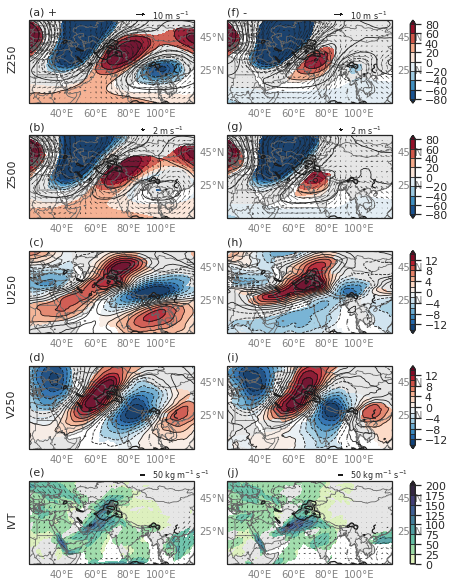

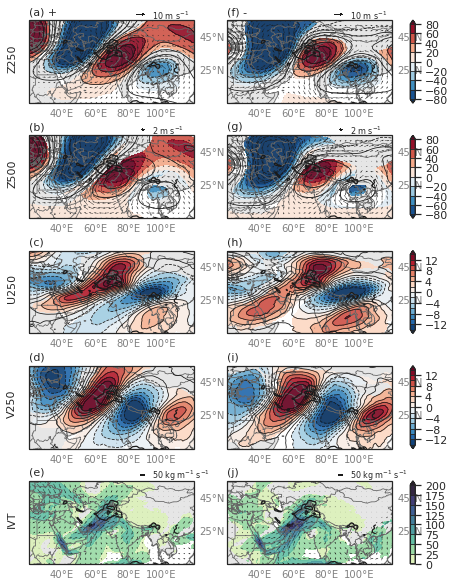

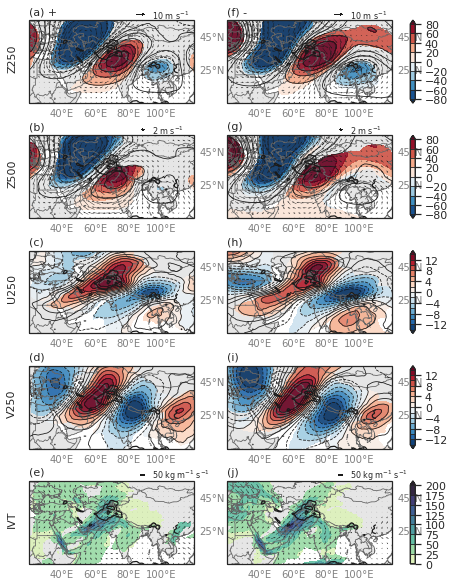

/home/sbarc/students/nash/miniconda3/envs/ar_types/lib/python3.7/site-packages/matplotlib/contour.py:1494: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/home/sbarc/students/nash/miniconda3/envs/ar_types/lib/python3.7/site-packages/matplotlib/contour.py:1495: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())
/home/sbarc/students/nash/miniconda3/envs/ar_types/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1478: UserWarning: No contour levels were found within the data range.
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)
/home/sbarc/students/nash/miniconda3/envs/ar_types/lib/python3.7/site-packages/matplotlib/contour.py:1494: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/home/sbarc/students/nash/miniconda3/envs/ar_types/lib/python3.7/site-packages/matplotlib/contour.py:1495: UserWarning: Warning: converting a masked element to nan.
  self.zmin = flo

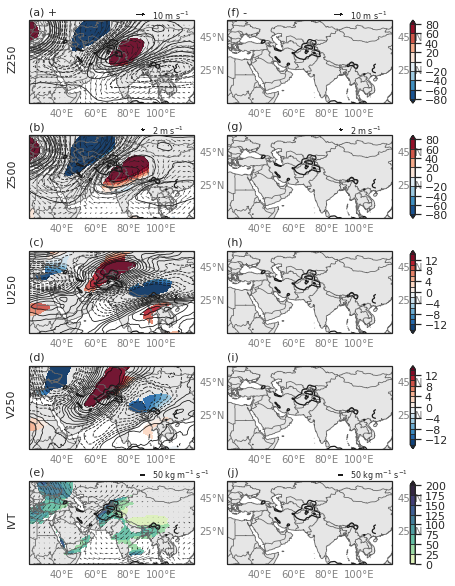

In [19]:
plot_ds = [data_lst[:2], data_lst[2:4], data_lst[4:6], test_data]
tval_ds = [tval_lst[:2], tval_lst[2:4], tval_lst[4:6], test_tval]
names = ['ENSO', 'AO', 'SH', 'Nino_AO']
for i, cliindex in enumerate(names):
    diff_data = plot_ds[i]
    tval_data = tval_ds[i]
    filepath = fig_path + 'composite_anom_' + cliindex + '.png'
    nrows = 5
    ncols = 2
    sig_level = True
    ext1 = [lonmin,lonmax,latmin,latmax]

    # Create figure
    fig = plt.figure(figsize=(15, 10))

    # Set up Axes Grid
    axes_class = (GeoAxes,dict(map_projection=mapcrs))
    axgr = AxesGrid(fig, 111, axes_class=axes_class,
                    nrows_ncols=(nrows, ncols), axes_pad = 0.45,
                    cbar_location='right', cbar_mode='edge',
                    cbar_pad=0.25, cbar_size='3%',label_mode='',
                    direction='row')
    
    #################################
    ########## UPPER PLOTS ##########
    #################################
    for k, ax in enumerate(axgr[0:ncols]):
        data = plot_ds[i][k]
        tval = tval_ds[i][k]
        plot_dict = plot_dict_upper
        # lat/lon arrays
        lats = data.lat.values
        lons = data.lon.values    
        ax = draw_basemap(ax, extent=ext1, xticks=dx, yticks=dy, left_lats=False, right_lats=True)

        uvec = data.U250.values
        vvec = data.V250.values
        hgts = data.H.values/(9.80665) # convert to geopotential height (m)

        uvec_mask = data.U250.where((tval.U250 == sig_level) | (tval.V250 == sig_level)).values
        vvec_mask = data.V250.where((tval.U250 == sig_level) | (tval.V250 == sig_level)).values
        hgts_mask = data.H.where((tval.H == sig_level)).values/(9.80665) # convert to geopotential height (m)

       # Contour Filled (significant)                           
        cflevs = clevs = np.arange(-80, 90, 20)
        cf = ax.contourf(lons, lats, hgts_mask, transform=datacrs,
                         levels=cflevs, cmap=plot_dict['cmap'], alpha=0.9, extend='both') 

        # Wind barbs / vectors
        Q = ax.quiver(lons, lats, uvec, vvec, transform=datacrs, 
                      color='k', regrid_shape=17, pivot='middle',
                      angles='xy', scale_units='xy', scale=plot_dict['quiver_scale'], units='xy')

        # quiver key
        qk = ax.quiverkey(Q, 0.7, 1.07, plot_dict['quiver_key'], plot_dict['quiver_key_lbl'], labelpos='E',
                              coordinates='axes', fontproperties={'size': 8.0})

        # Contour Lines (ALL)
        clevs = cflevs
        cs = ax.contour(lons, lats, hgts, transform=datacrs,
                        levels=clevs, colors='k', linewidths=0.8)

        # Contour Lines (Precip conditions)
        prec = precipitation.prec.sel(ar=3)
        clevs = np.array([5, 10, 20])
        prec_sm = gaussian_filter(prec.values, sigma=2.0)
        cs = ax.contour(prec.lon, prec.lat, prec_sm, transform=datacrs,
                        levels=clevs, colors='k', linewidths=1.25)
        # subtitles
        ax.set_title(col_lbl[0][k], loc='left',fontsize=11)
        # Row labels
        ax.text(-0.07, 0.55, row_lbl[0][k], va='bottom', ha='center',
            rotation='vertical', rotation_mode='anchor', fontsize=11,
            transform=ax.transAxes)

        # Colorbar (single)
        cb = fig.colorbar(cf, axgr.cbar_axes[0], orientation='vertical', drawedges=True)
#         cb.set_label(plot_dict['cb_label'])
        
    ###################################
    ########## 500 hPa PLOTS ##########
    ###################################
    for k, ax in enumerate(axgr[ncols:ncols*2]):
        data = plot_ds[i][k]
        tval = tval_ds[i][k]
        plot_dict = plot_dict_500
        # lat/lon arrays
        lats = data.lat.values
        lons = data.lon.values    
        ax = draw_basemap(ax, extent=ext1, xticks=dx, yticks=dy, left_lats=False, right_lats=True)

        uvec = data.U500.values
        vvec = data.V500.values
        hgts = data.H500.values/(9.80665) # convert to geopotential height (m)

        uvec_mask = data.U250.where((tval.U500 == sig_level) | (tval.V500 == sig_level)).values
        vvec_mask = data.V250.where((tval.U500 == sig_level) | (tval.V500 == sig_level)).values
        hgts_mask = data.H.where((tval.H500 == sig_level)).values/(9.80665) # convert to geopotential height (m)

       # Contour Filled (significant)                           
        cflevs = clevs = np.arange(-80, 90, 20)
        cf = ax.contourf(lons, lats, hgts_mask, transform=datacrs,
                         levels=cflevs, cmap='RdBu_r', alpha=0.9, extend='both') 

        # Wind barbs / vectors
        Q = ax.quiver(lons, lats, uvec, vvec, transform=datacrs, 
                      color='k', regrid_shape=17, pivot='middle',
                      angles='xy', scale_units='xy', scale=plot_dict['quiver_scale'], units='xy')

        # quiver key
        qk = ax.quiverkey(Q, 0.7, 1.07, plot_dict['quiver_key'], plot_dict['quiver_key_lbl'], labelpos='E',
                              coordinates='axes', fontproperties={'size': 8.0})

        # Contour Lines (ALL)
        clevs = cflevs
        cs = ax.contour(lons, lats, hgts, transform=datacrs,
                        levels=clevs, colors='k', linewidths=0.8)

        # Contour Lines (Precip conditions)
        prec = precipitation.prec.sel(ar=3)
        clevs = np.array([5, 10, 20])
        prec_sm = gaussian_filter(prec.values, sigma=2.0)
        cs = ax.contour(prec.lon, prec.lat, prec_sm, transform=datacrs,
                        levels=clevs, colors='k', linewidths=1.25)
        # subtitles
        ax.set_title(col_lbl[1][k], loc='left',fontsize=11)
        # Row labels
        ax.text(-0.07, 0.55, row_lbl[1][k], va='bottom', ha='center',
            rotation='vertical', rotation_mode='anchor', fontsize=11,
            transform=ax.transAxes)

        # Colorbar (single)
        cb = fig.colorbar(cf, axgr.cbar_axes[1], orientation='vertical', drawedges=True)
#         cb.set_label(plot_dict['cb_label'])

    ################################
    ########## U250 PLOTS ##########
    ################################
    for k, ax in enumerate(axgr[ncols*2:ncols*3]):
        data = plot_ds[i][k]
        tval = tval_ds[i][k]
        plot_dict = plot_dict_upper
        # lat/lon arrays
        lats = data.lat.values
        lons = data.lon.values    
        ax = draw_basemap(ax, extent=ext1, xticks=dx, yticks=dy, left_lats=False, right_lats=True)

        uvec = data.U250.values
        uvec_mask = data.U250.where((tval.U250 == sig_level) | (tval.V250 == sig_level)).values
        
        # Contour Filled (significant)                           
        cflevs = clevs = np.arange(-14, 16, 2)
        cf = ax.contourf(lons, lats, uvec_mask, transform=datacrs,
                         levels=cflevs, cmap=plot_dict['cmap'], alpha=0.9, extend='both')
        
        # Contour Lines (ALL)
        clevs = cflevs
        cs = ax.contour(lons, lats, uvec, transform=datacrs,
                        levels=clevs, colors='k', linewidths=0.8)

        # Contour Lines (Precip conditions)
        prec = precipitation.prec.sel(ar=3)
        clevs = np.array([5, 10, 20])
        prec_sm = gaussian_filter(prec.values, sigma=2.0)
        cs = ax.contour(prec.lon, prec.lat, prec_sm, transform=datacrs,
                        levels=clevs, colors='k', linewidths=1.25)
        # subtitles
        ax.set_title(col_lbl[2][k], loc='left',fontsize=11)
        # Row labels
        ax.text(-0.07, 0.55, row_lbl[2][k], va='bottom', ha='center',
            rotation='vertical', rotation_mode='anchor', fontsize=11,
            transform=ax.transAxes)

        # Colorbar (single)
        cb = fig.colorbar(cf, axgr.cbar_axes[2], orientation='vertical', drawedges=True)
#         cb.set_label(plot_dict['cb_label'])
        
    ################################
    ########## V250 PLOTS ##########
    ################################
    for k, ax in enumerate(axgr[ncols*3:ncols*4]):
        data = plot_ds[i][k]
        tval = tval_ds[i][k]
        plot_dict = plot_dict_upper
        # lat/lon arrays
        lats = data.lat.values
        lons = data.lon.values    
        ax = draw_basemap(ax, extent=ext1, xticks=dx, yticks=dy, left_lats=False, right_lats=True)

        vvec = data.V250.values
        vvec_mask = data.V250.where((tval.U250 == sig_level) | (tval.V250 == sig_level)).values
        
        # Contour Filled (significant)                           
        cflevs = clevs = np.arange(-14, 16, 2)
        cf = ax.contourf(lons, lats, vvec_mask, transform=datacrs,
                         levels=cflevs, cmap=plot_dict['cmap'], alpha=0.9, extend='both') 

        
        # Contour Lines (ALL)
        clevs = cflevs
        cs = ax.contour(lons, lats, vvec, transform=datacrs,
                        levels=clevs, colors='k', linewidths=0.8)

        # Contour Lines (Precip conditions)
        prec = precipitation.prec.sel(ar=3)
        clevs = np.array([5, 10, 20])
        prec_sm = gaussian_filter(prec.values, sigma=2.0)
        cs = ax.contour(prec.lon, prec.lat, prec_sm, transform=datacrs,
                        levels=clevs, colors='k', linewidths=1.25)
        # subtitles
        ax.set_title(col_lbl[3][k], loc='left',fontsize=11)
        # Row labels
        ax.text(-0.07, 0.55, row_lbl[3][k], va='bottom', ha='center',
            rotation='vertical', rotation_mode='anchor', fontsize=11,
            transform=ax.transAxes)

        # Colorbar (single)
        cb = fig.colorbar(cf, axgr.cbar_axes[3], orientation='vertical', drawedges=True)
#         cb.set_label(plot_dict['cb_label'])
        
    ################################
    ########## IVT PLOTS ###########
    ################################
    for k, ax in enumerate(axgr[ncols*4:]):
        data = plot_ds[i][k]
        tval = tval_ds[i][k]
        plot_dict = plot_dict_ivt
        # lat/lon arrays
        lats = data.lat.values
        lons = data.lon.values    
        ax = draw_basemap(ax, extent=ext1, xticks=dx, yticks=dy, left_lats=False, right_lats=True)

        uvec = data.ivte.values
        vvec = data.ivtn.values
#         ivt = data.ivt.values
        uvec_mask = data.ivte.where((tval.ivte == True) | (tval.ivtn == True)).values
        vvec_mask = data.ivtn.where((tval.ivte == True) | (tval.ivtn == True)).values
        ivt_mask = np.sqrt(uvec_mask**2+vvec_mask**2)
    
       # Contour Filled (significant)                           
        cflevs =  np.arange(0, 225, 25)
        cf = ax.contourf(lons, lats, ivt_mask, transform=datacrs,
                         levels=cflevs, cmap=plot_dict['cmap'], alpha=0.9, extend='max') 

        # Wind barbs / vectors
        Q = ax.quiver(lons, lats, uvec, vvec, transform=datacrs, 
                      color='k', regrid_shape=17, pivot='middle',
                      angles='xy', scale_units='xy', scale=plot_dict['quiver_scale'], units='xy')

        # quiver key
        qk = ax.quiverkey(Q, 0.7, 1.07, plot_dict['quiver_key'], plot_dict['quiver_key_lbl'], labelpos='E',
                              coordinates='axes', fontproperties={'size': 8.0})

        # Contour Lines (Precip conditions)
        prec = precipitation.prec.sel(ar=3)
        clevs = np.array([5, 10, 20])
        prec_sm = gaussian_filter(prec.values, sigma=2.0)
        cs = ax.contour(prec.lon, prec.lat, prec_sm, transform=datacrs,
                        levels=clevs, colors='k', linewidths=1.25)
        # subtitles
        ax.set_title(col_lbl[4][k], loc='left',fontsize=11)
        # Row labels
        ax.text(-0.07, 0.55, row_lbl[4][k], va='bottom', ha='center',
            rotation='vertical', rotation_mode='anchor', fontsize=11,
            transform=ax.transAxes)

        # Colorbar (single)
        cb = fig.colorbar(cf, axgr.cbar_axes[4], orientation='vertical', drawedges=True)
#         cb.set_label(plot_dict['cb_label'])
        
    # Save figure
    plt.savefig(filepath, dpi=300, bbox_inches='tight')

    # Show
    plt.show()